# Stock Price Prediction (Part 1 of 2)

**Problem Statement**

The objective is to create a predictive model to forecast future stock closing prices.

For the purpose of this presentation I will be showcasing the AMD stock ticker. 

**Model Explored**

|Models|Description|
|---|---|
|ARIMA|Autoregressive Integrated Moving Average|
|SARIMAX|Seasonal AutoRegressive Integrated Moving Averages|

**Workflow Process**  
1. Notebook 1 of 2 : ARIMA & SARIMAX : Data Collection
2. Notebook 1 of 2 : ARIMA & SARIMAX : General EDA
3. Notebook 1 of 2 : ARIMA & SARIMAX : Pre-Processing
4. Notebook 1 of 2 : ARIMA & SARIMAX : Modeling
5. Notebook 2 of 2 : GRU & LSTM : Data Collection
6. Notebook 2 of 2 : GRU & LSTM : General EDA
7. Notebook 2 of 2 : GRU & LSTM : Pre-Processing
7. Notebook 2 of 2 : GRU & LSTM : Modeling

# 0.0 Libraries Import

In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import impyute as impy

from math import sqrt
from pandas import Series
from numpy import isnan
from datetime import datetime
from datetime import timedelta
from time import time
from pandas.tseries.offsets import DateOffset

from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import PowerTransformer
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

# 1.0 Data Import

In [2]:
# from secrets2 import key

In [3]:
# df = pdr.get_data_tiingo('AMD', api_key=key)

In [4]:
# df.to_csv('AMD.csv')

In [5]:
df = pd.read_csv('AMD.csv')

In [6]:
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AMD,2016-12-19 00:00:00+00:00,10.950,11.000,10.520,10.810,46085840,10.950,11.000,10.520,10.810,46085840,0.000,1.000
1,AMD,2016-12-20 00:00:00+00:00,11.510,11.510,11.150,11.190,59314159,11.510,11.510,11.150,11.190,59314159,0.000,1.000
2,AMD,2016-12-21 00:00:00+00:00,11.470,11.720,11.310,11.610,44814131,11.470,11.720,11.310,11.610,44814131,0.000,1.000
3,AMD,2016-12-22 00:00:00+00:00,11.600,11.750,11.470,11.650,36450756,11.600,11.750,11.470,11.650,36450756,0.000,1.000
4,AMD,2016-12-23 00:00:00+00:00,11.580,11.600,11.260,11.300,32288235,11.580,11.600,11.260,11.300,32288235,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,AMD,2021-12-10 00:00:00+00:00,138.550,141.365,135.820,141.290,42224275,138.550,141.365,135.820,141.290,42224275,0.000,1.000
1254,AMD,2021-12-13 00:00:00+00:00,133.800,139.400,133.415,138.250,42173963,133.800,139.400,133.415,138.250,42173963,0.000,1.000
1255,AMD,2021-12-14 00:00:00+00:00,135.600,137.240,130.600,131.670,50754642,135.600,137.240,130.600,131.670,50754642,0.000,1.000
1256,AMD,2021-12-15 00:00:00+00:00,146.500,146.690,133.810,135.110,72425783,146.500,146.690,133.810,135.110,72425783,0.000,1.000


# 2.0 General EDA
___

* 2.1 Pre-processing of dates and prefered columns
* 2.2 Time Series Plot
* 2.3 Trend & Seasonality

### 2.1 Pre-processing of Dates and Prefered Columns
___

In [7]:
df['date'] = df['date'].map(lambda x : x[:-14])

In [8]:
# Add Year, Month, Week and Day of Week features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['week'] = df['date'].apply(lambda x: x.week)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)

In [9]:
df.set_index('date', inplace=True)

In [10]:
df1 = pd.DataFrame(df[['close','volume','year','month','week','dayofweek']].groupby(df.index).sum())

### 2.2 Time Series Plot
___

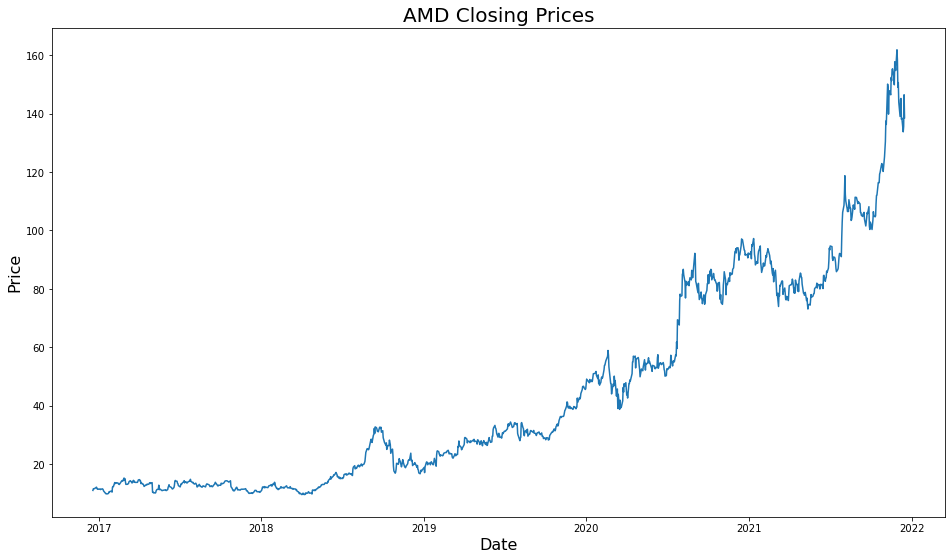

In [11]:
plt.figure(figsize=(16,9))
plt.title('AMD Closing Prices', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.plot(df1['close']);

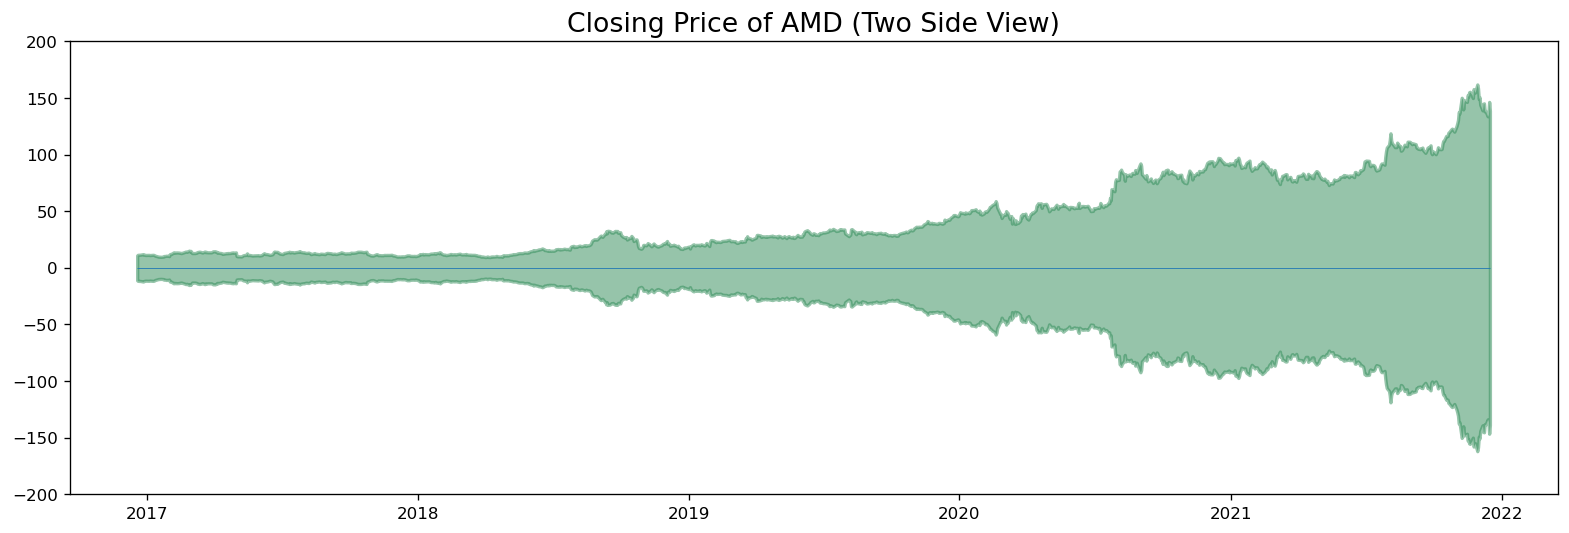

In [12]:
x = df1.index
y1 = df1['close'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-200, 200)
plt.title('Closing Price of AMD (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df1.index), xmax=np.max(df1.index), linewidth=.5)
plt.show()

### 2.3 Trend & Seasonality
___

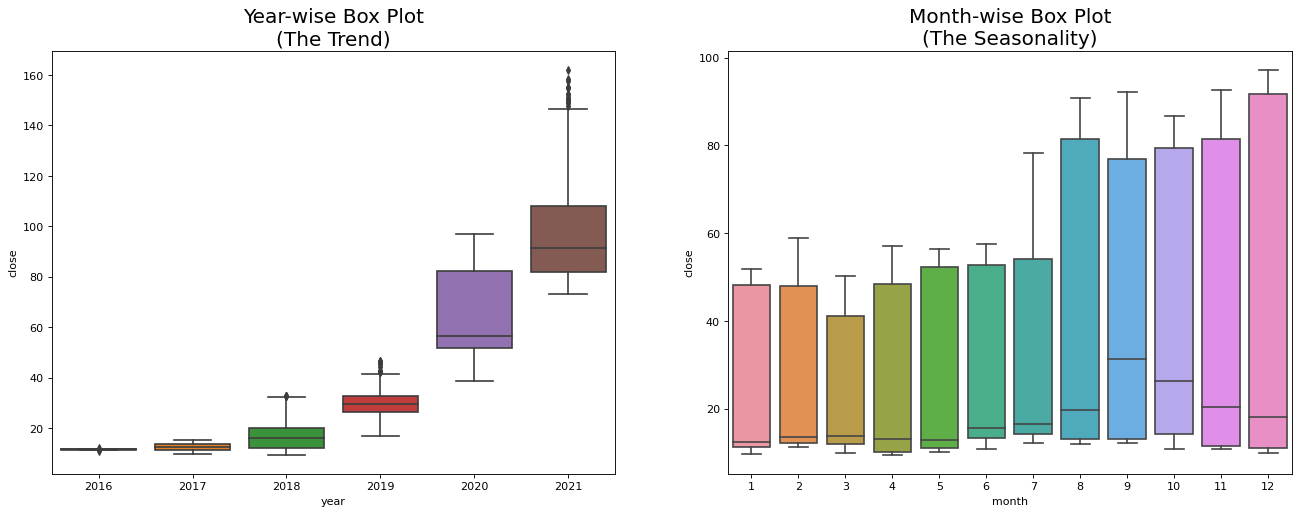

In [13]:
# Prepare data
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='close', data=df, ax=axes[0])
sns.boxplot(x='month', y='close', data=df.loc[~df.year.isin([2019, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [14]:
result = seasonal_decompose(df1['close'], model='additive', freq = 24)

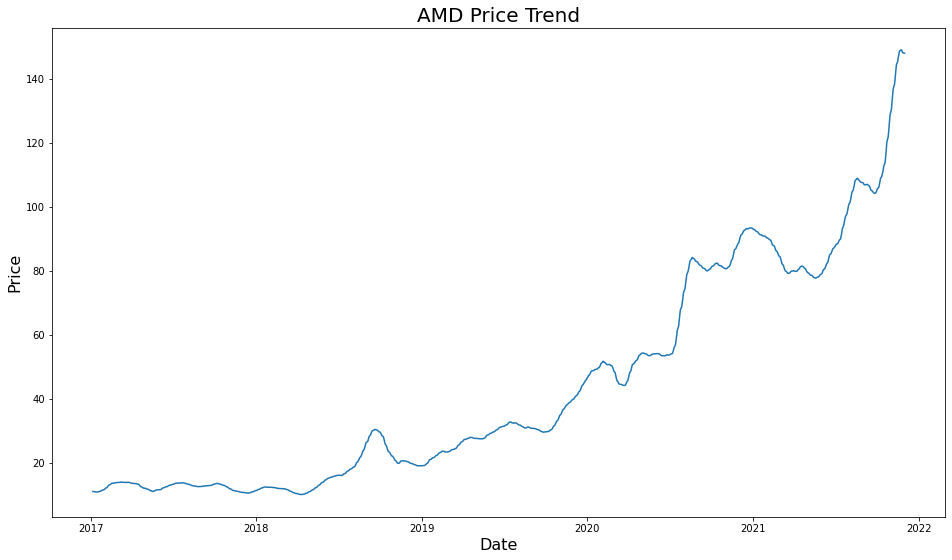

In [15]:
fig = plt.figure(figsize=(16,9))
plt.title('AMD Price Trend', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.plot(result.trend);

# 3.0 Pre-Processing
___

* 3.1 AdFuller Test
* 3.2 Autocorrelation and Partial Autocorrelation Test

In [16]:
df1 = df1['2020':]

### 3.1 AdFuller Test
___

In [17]:
test_result = adfuller(df1['close'])

In [18]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [19]:
adfuller_test(df1['close'])

ADF Test Statistic : -0.1856205771364987
p-value : 0.9402140424261141
#Lags Used : 1
Number of Observations Used : 493
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [20]:
df1['close_first_difference'] = df1['close'] - df1['close'].shift(1)

In [21]:
## Again test dickey fuller test
adfuller_test(df1['close_first_difference'].dropna())

ADF Test Statistic : -24.79557024019801
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 493
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [22]:
df1['seasonal_first_difference']=df1['close']-df1['close'].shift(24)

In [23]:
## Again test dickey fuller test
adfuller_test(df1['seasonal_first_difference'].dropna())

ADF Test Statistic : -5.439757731032842
p-value : 2.793269722804705e-06
#Lags Used : 18
Number of Observations Used : 452
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


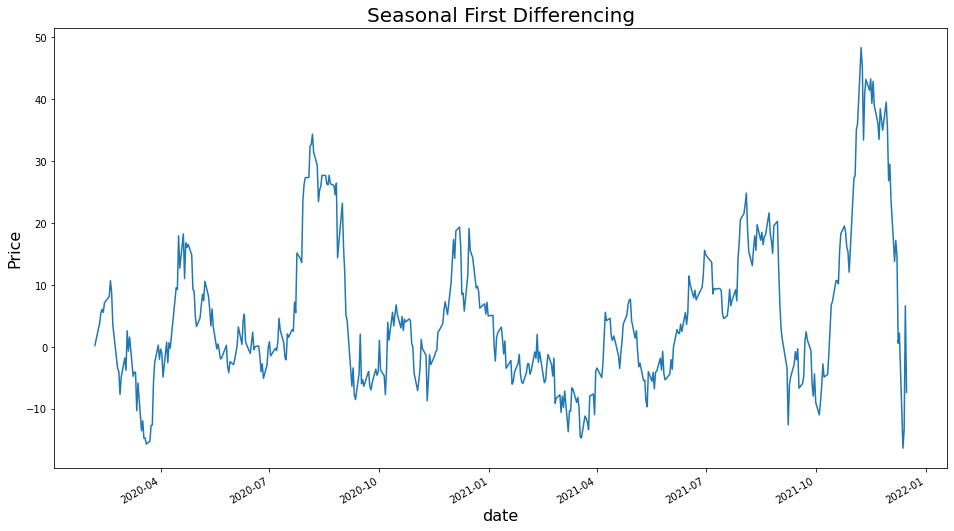

In [24]:
plt.figure(figsize=(16,9))
plt.title('Seasonal First Differencing', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
df1['seasonal_first_difference'].plot();

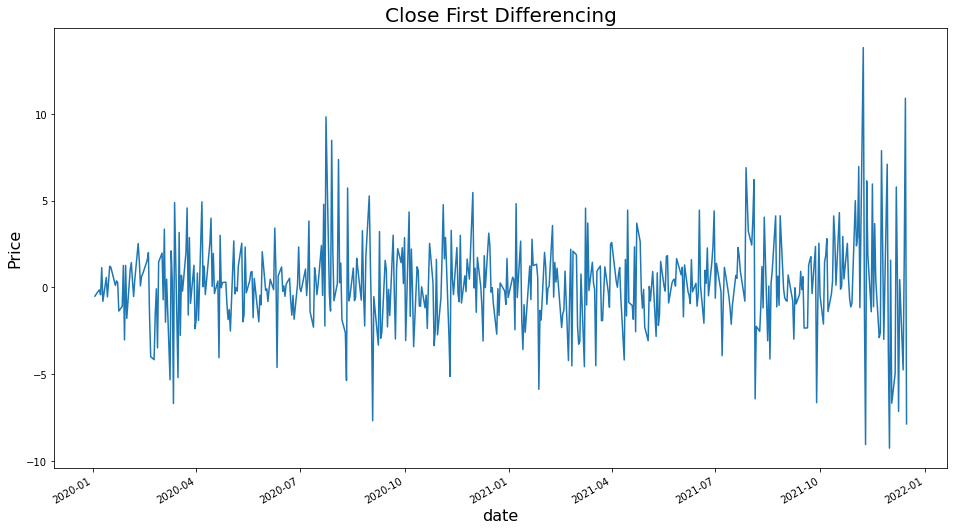

In [25]:
plt.figure(figsize=(16,9))
plt.title('Close First Differencing', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
df1['close_first_difference'].plot();

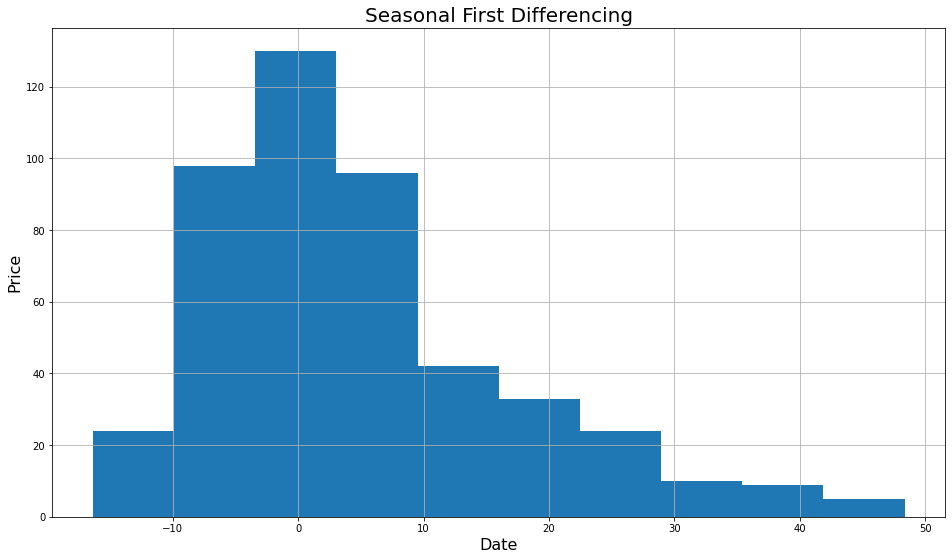

In [26]:
# histogram plot
fig = plt.figure(figsize=(16,9))
plt.title('Seasonal First Differencing', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
df1['seasonal_first_difference'].hist();

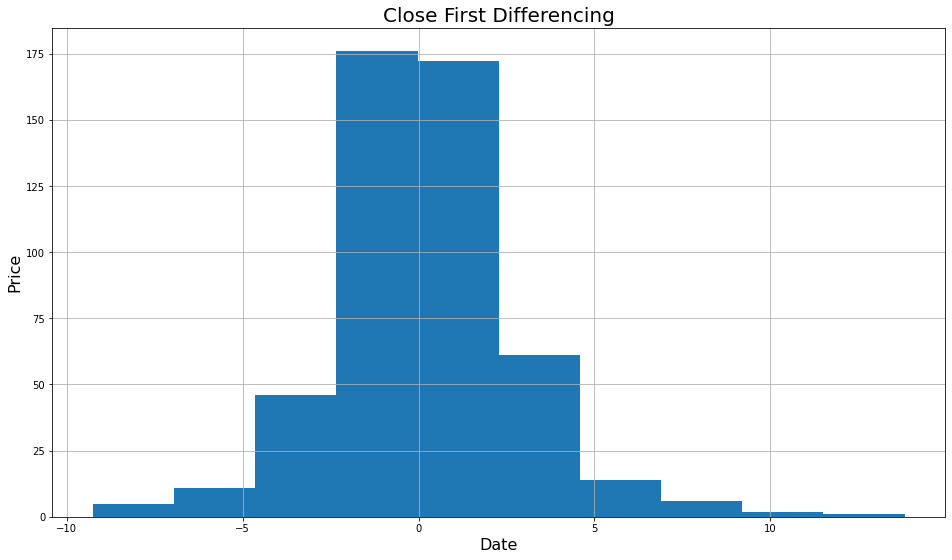

In [27]:
# histogram plot
fig = plt.figure(figsize=(16,9))
plt.title('Close First Differencing', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
df1['close_first_difference'].hist();

### 3.2 Autocorrelation and Partial Autocorrelation Test
___

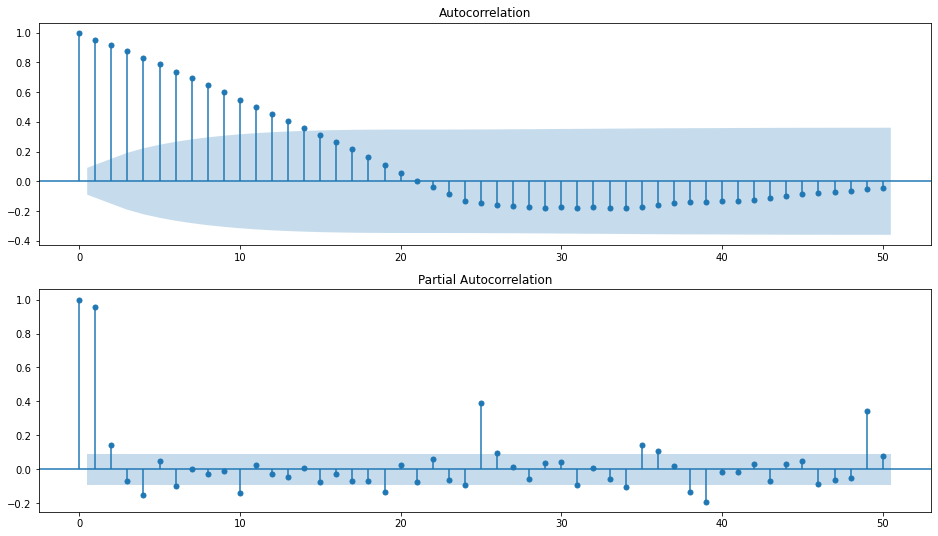

In [28]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1['seasonal_first_difference'].iloc[24:],lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1['seasonal_first_difference'].iloc[24:],lags=50,ax=ax2)

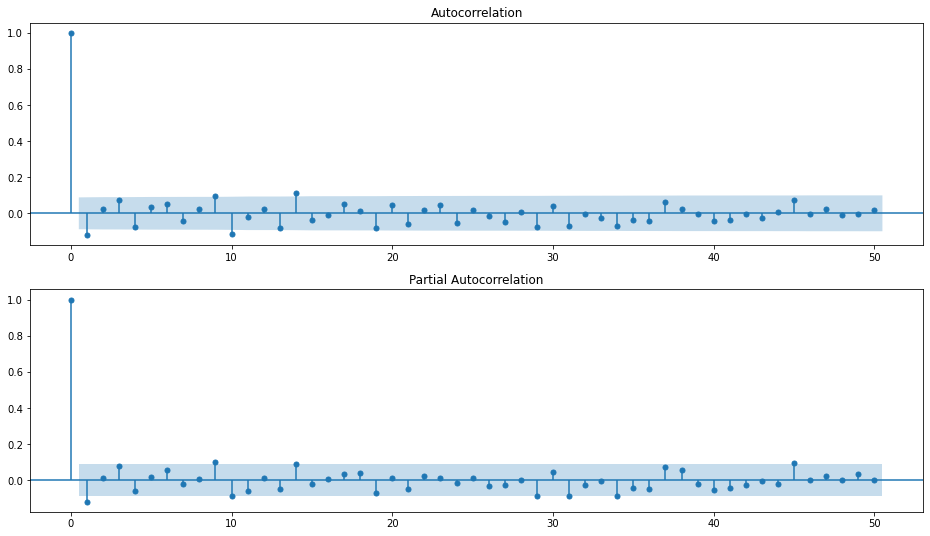

In [29]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1['close_first_difference'].iloc[1:],lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1['close_first_difference'].iloc[1:],lags=50,ax=ax2)

# 4.0 Modeling
___

* 4.1 Split Data (80% Train -20% Split)
* 4.2 Instantiate ARIMAX Model
* 4.3 Plot ARIMAX Predictions
* 4.4 Evaluate ARIMAX Predictions
* 4.5 Split Data (80% Train -20% Split)
* 4.6 Instantiate SARIMAX Model
* 4.7 Plot SARIMAX Predictions
* 4.8 Evaluate SARIMAX Predictions

### 4.1 Split Data (80% Train -20% Split)
___

In [30]:
# Create train-test split.
y_train, y_test = train_test_split(df1, test_size=.2, shuffle=False)

### 4.2 Instantiate ARIMAX Model
___

In [31]:
# Instantiate an ARIMA model on training data.

ar1 = ARIMA(endog = y_train['close'].iloc[24:],
            order = (1, 1, 1),
            exog = y_train['seasonal_first_difference'].iloc[24:]) # (p, d, q)

# Fit model.
model = ar1.fit()

# Generate predictions based on test set.
# Start at time period 1005 and end at 1233.
preds = model.predict(start=397, end=470, exog=y_test[['seasonal_first_difference']].iloc[0:])

### 4.3 Plot ARIMAX Predictions
___

In [32]:
y_test.drop(index=y_test.index[:25], 
        axis=0, 
        inplace=True)

In [33]:
y_test['preds'] = preds.values

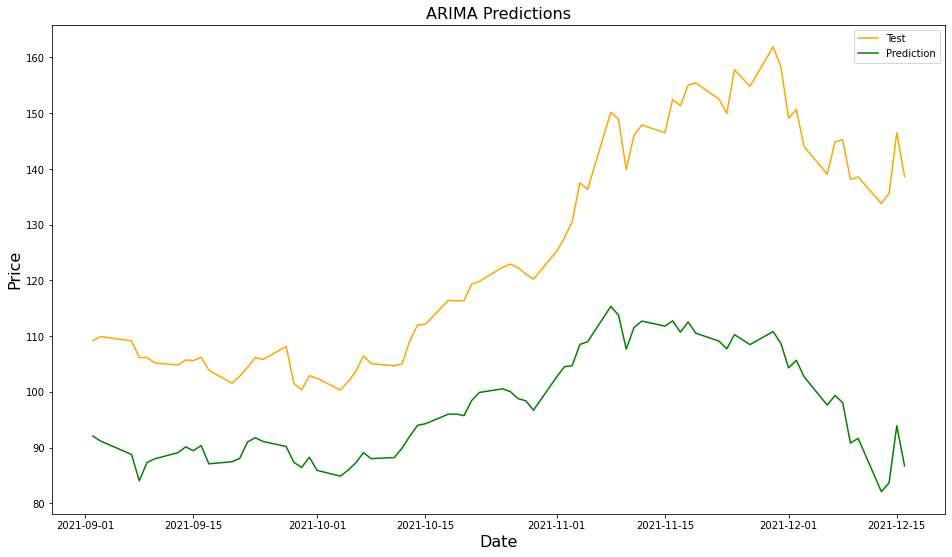

In [34]:
# Plot data.
plt.figure(figsize=(16,9))
plt.plot(y_test['close'], color = 'orange', label = 'Test')
plt.plot(y_test['preds'], color = 'green', label = 'Prediction')
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title(label = 'ARIMA Predictions', fontsize=16)
plt. legend(loc='best')
plt.show();

### 4.4 Evaluate ARIMA Predictions
___

In [35]:
def mape(actual, pred): 
    actual, pred = np.array(y_test['close']), np.array(y_test['preds'])
    return np.mean(np.abs((y_test['close'] - y_test['preds']) / actual)) * 100

In [36]:
result = mape(y_test['close'],y_test['preds'])

In [37]:
print(f'The average difference between the predicted value and the actual value is {result}%')

The average difference between the predicted value and the actual value is 21.501701647794487%


### 4.5 Split Data (80% Train -20% Split)
___

In [38]:
# Create train-test split.
y_train, y_test = train_test_split(df1, test_size=.2, shuffle=False)

### 4.6 Instantiate SARIMAX Model
___

In [39]:
# Fit and visualize a SARIMAX(1, 1, 1) x (1, 1, 1, 24) model.

sarima = SARIMAX(endog = y_train['close'].iloc[24:],
                 order = (1, 1, 1),              # (p, d, q)
                 seasonal_order = (1, 1, 1, 24), # (P, D, Q, S)
                 exog = y_train['seasonal_first_difference'].iloc[24:])

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 1005 and end at 1233.
preds = model.predict(start=397, end=470, exog=y_test[['seasonal_first_difference']].iloc[0:])

In [40]:
y_test.drop(index=y_test.index[:25], 
        axis=0, 
        inplace=True)

### 4.7 Plot SARIMAX Predictions
___

In [41]:
y_test['preds'] = preds.values

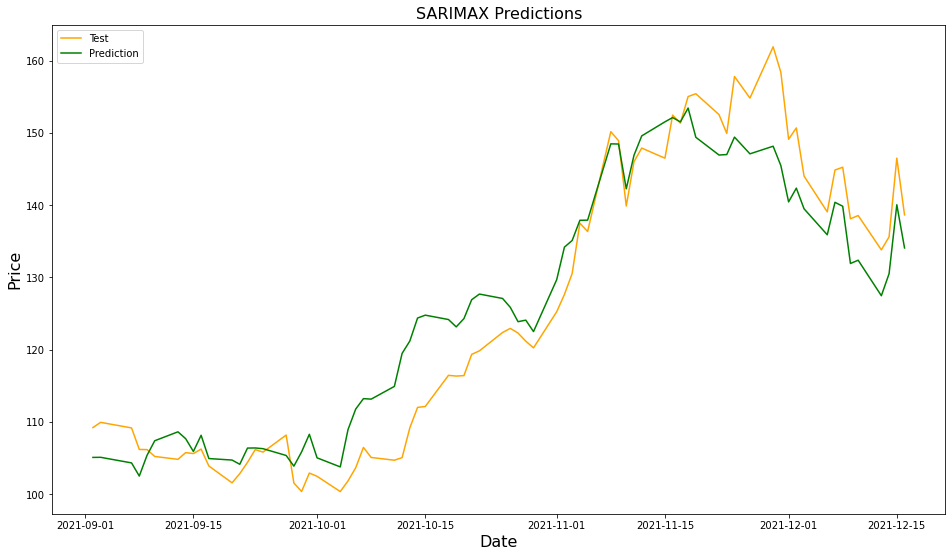

In [42]:
# Plot data.
plt.figure(figsize=(16,9))
plt.plot(y_test['close'], color = 'orange', label = 'Test')
plt.plot(y_test['preds'], color = 'green', label = 'Prediction')
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title(label = 'SARIMAX Predictions', fontsize=16)
plt. legend(loc='upper left')
plt.show();

### 4.8 Evaluate SARIMAX Predictions
___

In [43]:
result = mape(y_test['close'],y_test['preds'])

In [44]:
print(f'The average difference between the predicted value and the actual value is {result}%')

The average difference between the predicted value and the actual value is 3.9725333214500607%
